# Miniproject 1: Image Classification

## Introduction

### Important dates:

- Project release: Friday, 15th March 2019
- **Submission deadline**: Monday, 29th April 2019, 11:59 pm

### Description

One of the deepest traditions in learning about deep learning is to first [tackle the exciting problem of MNIST classification](http://yann.lecun.com/exdb/mnist/). [The MNIST database](https://en.wikipedia.org/wiki/MNIST_database) (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that is commonly used as a first test for new classification algorithms. 
We follow this tradition to investigate the performance of artificial neural networks of different complexity on MNIST. However, since MNIST is too easy for accessing the full power of modern machine learning algorithms (see e.g. [this post](https://twitter.com/goodfellow_ian/status/852591106655043584)) we will extend our analysis to the recently introduced, harder [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist).


### Prerequisites

- You should have a running installation of [tensorflow](https://www.tensorflow.org/install/) and [keras](https://keras.io/). Feel free to gain inspiration from the [Keras example directory](https://github.com/keras-team/keras/tree/master/examples) for your implementations.
- You should know the concepts "multilayer perceptron", "stochastic gradient descent with minibatches", "convolutional neural network", "training and validation data", "overfitting" and "early stopping".

### What you will learn

- You will learn how to define feedforward neural networks in keras and fit them to data.
- You will be guided through a prototyping procedure for the application of deep learning to a specific domain.
- You will get in contact with concepts discussed later in the lecture, like "regularization", "batch normalization" and "convolutional networks".
- You will gain some experience on the influence of network architecture, optimizer and regularization choices on the goodness of fit.
- You will learn to be more patient :) Some fits may take your computer quite a bit of time; run them over night (or on an external server).

### Evaluation criteria

The evaluation is (mostly) based on the figures you submit and your answer sentences. Provide clear and concise answers respecting the indicated maximum length (answers to the questions should be below the line that says "Answer to question ...").

**The submitted notebook must be run by you!** We will only do random tests of your code and not re-run the full notebook. There will be fraud detection sessions at the end of the semester.

### Your names

**Before you start**: please enter your full name(s) in the field below.

In [1]:
student1 = "Huajian Qiu"
student2 = "Kunteng Wang"

## Some helper functions

For your convenience we provide here some functions to preprocess the data and plot the results later. Simply run the following cells with `Shift-Enter`.

### Dependencies and constants

In [2]:
%matplotlib inline

import numpy as np
import time
import matplotlib.pyplot as plt
#import scipy.io
#import skimage.io

import keras
from keras.datasets import mnist
from keras.datasets import fashion_mnist
from keras.layers import Activation
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.optimizers import SGD, Adam
from keras.layers import BatchNormalization
from keras.regularizers import Regularizer
from keras import regularizers
from keras import backend as K

Using TensorFlow backend.


### Plotting

In [5]:
def plot_some_samples(x, y = [], yhat = [], select_from = [], 
                      ncols = 6, nrows = 4, xdim = 28, ydim = 28,
                      label_mapping = range(10)):
    """plot some input vectors as grayscale images (optionally together with their assigned or predicted labels).
    
    x is an NxD - dimensional array, where D is the length of an input vector and N is the number of samples.
    Out of the N samples, ncols x nrows indices are randomly selected from the list select_from (if it is empty, select_from becomes range(N)).
    
    Keyword arguments:
    y             -- corresponding labels to plot in green below each image.
    yhat          -- corresponding predicted labels to plot in red below each image.
    select_from   -- list of indices from which to select the images.
    ncols, nrows  -- number of columns and rows to plot.
    xdim, ydim    -- number of pixels of the images in x- and y-direction.
    label_mapping -- map labels to digits.
    """
    fig, ax = plt.subplots(nrows, ncols)
    if len(select_from) == 0:
        select_from = range(x.shape[0])
    indices = np.random.choice(select_from, size = min(ncols * nrows, len(select_from)), replace = False)
    for i, ind in enumerate(indices):
        thisax = ax[i//ncols,i%ncols]
        thisax.matshow(x[ind].reshape(xdim, ydim), cmap='gray')
        thisax.set_axis_off()
        if len(y) != 0:
            j = y[ind] if type(y[ind]) != np.ndarray else y[ind].argmax()
            #j = 'hello' if type(y[ind]) != np.ndarray else y[ind].argmax()
            thisax.text(0, 0, (label_mapping[j]+1)%10, color='green', 
                                                       verticalalignment='top',
                                                       transform=thisax.transAxes)
        if len(yhat) != 0:
            k = yhat[ind] if type(yhat[ind]) != np.ndarray else yhat[ind].argmax()
            thisax.text(1, 0, (label_mapping[k]+1)%10, color='red',
                                             verticalalignment='top',
                                             horizontalalignment='right',
                                             transform=thisax.transAxes)
    return fig

def my_plot_some_samples(x, y = [], yhat = [], select_from = [], 
                      ncols = 6, nrows = 4, xdim = 28, ydim = 28,
                      label_mapping = range(10)):
    fig, ax = plt.subplots(nrows, ncols)
    if len(select_from) == 0:
        select_from = range(x.shape[0])
    indices = np.random.choice(select_from, size = min(ncols * nrows, len(select_from)), replace = False)
    for i, ind in enumerate(indices):
        thisax = ax[i//ncols,i%ncols]
        thisax.matshow(x[ind].reshape(xdim, ydim), cmap='gray')
        thisax.set_axis_off()
        if len(y) != 0:
            j = y[ind] if type(y[ind]) != np.ndarray else y[ind].argmax()
            #j = 'hello' if type(y[ind]) != np.ndarray else y[ind].argmax()
            thisax.text(0, 0, (label_mapping[j])%10, color='green', 
                                                       verticalalignment='top',
                                                       transform=thisax.transAxes)
        if len(yhat) != 0:
            k = yhat[ind] if type(yhat[ind]) != np.ndarray else yhat[ind].argmax()
            thisax.text(1, 0, (label_mapping[k])%10, color='red',
                                             verticalalignment='top',
                                             horizontalalignment='right',
                                             transform=thisax.transAxes)
    return fig

def prepare_standardplot(title, xlabel):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(title)
    ax1.set_ylabel('categorical cross entropy')
    ax1.set_xlabel(xlabel)
    ax1.set_yscale('log')
    ax2.set_ylabel('accuracy [% correct]')
    ax2.set_xlabel(xlabel)
    return fig, ax1, ax2

def finalize_standardplot(fig, ax1, ax2):
    ax1handles, ax1labels = ax1.get_legend_handles_labels()
    if len(ax1labels) > 0:
        ax1.legend(ax1handles, ax1labels)
    ax2handles, ax2labels = ax2.get_legend_handles_labels()
    if len(ax2labels) > 0:
        ax2.legend(ax2handles, ax2labels)
    fig.tight_layout()
    plt.subplots_adjust(top=0.9)

def plot_history(history, title):
    fig, ax1, ax2 = prepare_standardplot(title, 'epoch')
    fig.set_figheight(5)
    fig.set_figwidth(10)
    fig.suptitle(title)
    ax1.plot(history.history['loss'], label = "training")
    ax1.plot(history.history['val_loss'], label = "validation")
    
    ax2.plot(history.history['acc'], label = "training")
    ax2.plot(history.history['val_acc'], label = "validation")
    finalize_standardplot(fig, ax1, ax2)
    return fig

## Exercise 1: Data import and visualization (4 points)

### Description

### Loading the data

The datasets we use in this project (MNIST, Fashion-MNIST) consists of grayscale images with 28x28 pixels. Keras comes with a convenient in-built [data importer](https://keras.io/datasets/) for common datasets.

1. As a warm-up exercise, use this importer to (down-)load the MNIST and Fashion-MNIST dataset. Assign useful variables to test & train images and labels for both datasets respectively. (2 pts)
2. Use the corresponding plotting function defined above to plot some samples of the two datasets. What do the green digits at the bottom left of each image indicate? (1 sentence max.) (2 pts)

The low resolution (and grayscale) of the images certainly misses some information that could be helpful for classifying the images. However, since the data has lower dimensionality due to the low resolution, the fitting procedures converge faster. This is an advantage in situations like here (or generally when prototyping), were we want to try many different things without having to wait too long for computations to finish.



### Solution

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
(x_fashion_train, y_fashion_train), (x_fashion_test, y_fashion_test) = fashion_mnist.load_data()
print("the dimension of x_train is : ",x_train.shape)
print("the dimension of x_test is :",x_test.shape)
print("the dimension of y_train is : ",y_train.shape)
print("the dimension of y_test is : ",y_test.shape)
print("the lenght of vector is 28x28 =",x_test.shape[1]*x_test.shape[2])
print("fashion is of the same case")

Answer to question 2:
The green digits at the bottom left of each image indicate the correct label of the image plus one(e.g., when the label is 9, the green digits is zero)

In [ ]:
my_plot_some_samples(x_train, y_train)

In [ ]:
my_plot_some_samples(x_fashion_train, y_fashion_train)

**Data pre-processing**: To prepare for fitting we transform the labels to one hot coding, i.e. for 5 classes, label 2 becomes the vector [0, 0, 1, 0, 0] (python uses 0-indexing). Furthermore we reshape (flatten) the input images to input vectors and rescale the data into the range [0,1].

In [9]:
ty_train = keras.utils.to_categorical(y_train)
ty_test = keras.utils.to_categorical(y_test)
ty_fashion_train = keras.utils.to_categorical(y_fashion_train)
ty_fashion_test = keras.utils.to_categorical(y_fashion_test)

tx_train = (x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2])/np.max(x_train)).astype('float32')
tx_test = (x_test.reshape(x_test.shape[0], x_test.shape[1]*x_test.shape[2])/np.max(x_test)).astype('float32')
tx_fashion_train = (x_fashion_train.reshape(x_fashion_train.shape[0], 
                                           x_fashion_train.shape[1]*x_fashion_train.shape[2])/ np.max(x_fashion_train)).astype('float32')
tx_fashion_test = (x_fashion_test.reshape(x_fashion_test.shape[0], 
                                           x_fashion_test.shape[1]*x_fashion_test.shape[2]) / np.max(x_fashion_test)).astype('float32')
print("After the pre-processing, the demension of x_train is ", tx_train.shape)
print("After the pre-processing, the demension of y_train is ", ty_train.shape)

('After the pre-processing, the demension of x_train is ', (60000, 784))
('After the pre-processing, the demension of y_train is ', (60000, 10))


## Exercise 2: No hidden layer (10 points)

### Description

Define and fit a model without a hidden layer (since we will use multi-layer models later in this project, you can define a general constructor function for models with an arbitrary number of hidden layers already at this point). (1 pt for each step)

1. Use the softmax activation for the output layer.
2. Use the categorical_crossentropy loss.
3. Add the accuracy metric to the metrics.
4. Choose stochastic gradient descent for the optimizer.
5. Choose a minibatch size of 128.
6. Fit for as many epochs as needed to see no further decrease in the validation loss.
7. Plot the output of the fitting procedure (a history object) using the function plot_history defined above.
8. Determine the indices of all test images that are misclassified by the fitted model and plot some of them using the function 
   `plot_some_samples(x_test, y_test, yhat_test, error_indices)`. Explain the green and red digits at the bottom of each image.
9. Repeat the above steps for fitting the network to the Fashion-MNIST dataset.


Hints:
* Read the keras docs, in particular [Getting started with the Keras Sequential model](https://keras.io/getting-started/sequential-model-guide/).
* Have a look at the keras [examples](https://github.com/keras-team/keras/tree/master/examples), e.g. [mnist_mlp](https://github.com/keras-team/keras/blob/master/examples/mnist_mlp.py).

### Solution

In [36]:
class DataSet:
    def __init__(self, x, y, x_val, y_val):
        self.x = x
        self.y = y
        self.x_val = x_val
        self.y_val = y_val

class NeuroNetSolver:
    def learning(self,data):
        self.history = self.model.fit(data.x, data.y, 
                   batch_size = 128,
                   epochs = 50,
                   verbose = 0,
                   validation_data = (data.x_val, data.y_val))
        return self.history
    def display(self, title):
        best_epoch = np.argmin(self.history.history['val_loss'])
        best_loss = self.history.history['val_loss'][best_epoch]
        best_accr = self.history.history['val_acc'][best_epoch]
        print('when the epoch = %d'%(best_epoch+1))
        print('best_loss_test = %.4f'%best_loss)
        print('best_accr_test = %.4f'%best_accr)
        fig = plot_history(self.history, title)
        return best_loss, best_accr
        
mnist_data = DataSet(tx_train, ty_train, tx_test, ty_test)
fashion_data = DataSet(tx_fashion_train,ty_fashion_train,tx_fashion_test,ty_fashion_test)

In [11]:
class NoHidden(NeuroNetSolver):
    def __init__(self):
        self.model = Sequential([Dense(10,input_dim=784),
                    Activation('softmax')])
        self.model.summary()
        self.model.compile(loss = 'categorical_crossentropy',  
               optimizer = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True),
               metrics = ['accuracy'])
    def plot_misclass(self,tx_test,x_test,y_test):
        y_est = self.model.predict_classes(tx_test)
        error_indices = np.where( y_est != y_test )[0]
        fig = my_plot_some_samples(x_test, y_test, y_est, error_indices)
        print('The dimension of y_est is ',y_est.shape)
        print('The number of error sample is %d out of %d'%(error_indices.shape[0],y_est.shape[0]))

In [ ]:
'''******************for the MNIST dataset*****************************'''
ex2_first = NoHidden()

ex2_first.learning(mnist_data)
title = 'no hidden layer on MNIST'
ex2_first.display(title)
ex2_first.plot_misclass(tx_test,x_test,y_test)

In [ ]:
'''******************for the Fashion-MNIST dataset*****************************'''
ex2_second = NoHidden()

ex2_second.learning(fashion_data)

In [ ]:
title = 'no hidden layer on Fashion-MNIST'
ex2_second.display(title)

The meaning of label is :
0 means T-shirt/top 
1 means Trouser 
2 means Pullover 
3 means Dress 
4 means Coat 
5 means Sandal 
6 means Shirt 
7 means Sneaker 
8 means Bag 
9 means Ankel boot 
The dimension of y_est is  (10000,)
The number of error sample is 1563 out of 10000


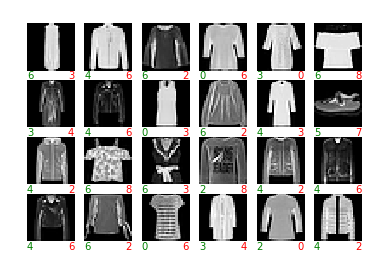

In [65]:
fashion_name = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt',
                'Sneaker', 'Bag', 'Ankel boot']
print('The meaning of label is :')
for i in range(10):
    print('%d means %s '%(i, fashion_name[i]))
ex2_second.plot_misclass(tx_fashion_test,x_fashion_test,y_fashion_test)

Answer to question 10: The green digits at the left bottom of each image indicate the correct label number and red digits at the right bottom of each image indicate the predicted label of network towards this image.

## Exercise 3: One hidden layer, different optizimizers & overfitting (10 points)

### Description

Train a network with one hidden layer and compare different optimizers.

1. Use one hidden layer with 128 units and the 'relu' activation. Use the [summary method](https://keras.io/models/about-keras-models/) to display your model in a compact way. (1 pt)
2. Fit the model for 50 epochs with different learning rates of stochastic gradient descent (SGD). (1pt)
3. Replace the stochastic gradient descent optimizer with the [Adam optimizer](https://keras.io/optimizers/#adam). (1pt)
4. Plot the learning curves of SGD with a reasonable learning rate (i.e. in the range [0.01,0.1]) together with the learning curves of Adam in the same figure. Take care of a reasonable labeling of the curves in the plot. (2pts)
5. Answer the questions below. (4pts)
6. Run the network (using the Adam optimizer) on the Fashion-MNIST dataset and plot the learning curves using the plot_history function defined above. (1pt)

### Solution

In [22]:
class OneHidden(NeuroNetSolver):
    def __init__(self,opt):
        self.model = Sequential([Dense(128,input_dim=784),
                    Activation('relu'),
                      Dropout(0.2),
                     Dense(10),
                    Activation('softmax')])
        self.model.summary()
        self.model.compile(loss = 'categorical_crossentropy',  
               optimizer = opt,
               metrics = ['accuracy'])
    def get_history(self):
        return self.history

# This plotting routine might help you ...
def comparison_plot(history_sgd, history_adam, label1, label2, title):
    fig, ax1, ax2 = prepare_standardplot(title, "epochs")
    fig.set_figheight(5)
    fig.set_figwidth(10)
    ax1.plot(history_sgd.history['loss'], label=label1 + ' training')
    ax1.plot(history_sgd.history['val_loss'], label=label1 + ' validation')
    ax1.plot(history_adam.history['loss'], label=label2 + ' training')
    ax1.plot(history_adam.history['val_loss'], label=label2 + ' validation')
    
    ax2.plot(history_sgd.history['acc'], label=label1 + ' training')
    ax2.plot(history_sgd.history['val_acc'], label=label1 + ' validation')
    ax2.plot(history_adam.history['acc'], label=label2 + ' training')
    ax2.plot(history_adam.history['val_acc'], label=label2 + ' validation')
    
    finalize_standardplot(fig, ax1, ax2)
    return fig

In [ ]:
'''******************for the MNIST dataset*****************************'''

opt = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
ex3_sgd = OneHidden(opt)

history_sgd = ex3_sgd.learning(mnist_data)
title = 'One hidden layer on MNIST'
ex3_sgd.display(title)
history_sgd = ex3_sgd.get_history()

In [ ]:
'''******************compare SGD and Adam optimizer*****************************'''

opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
ex3_adam = OneHidden(opt)
title = 'One hidden layer on MNIST'

history_adam = ex3_adam.learning(mnist_data)
ex3_adam.display(title)

In [ ]:
label1 = 'SGD_opt'
label2 = 'Adam_opt'
title = 'The difference between SGD and Adam optimizer in MNIST dataset'
fig = comparison_plot(history_sgd, history_adam, label1, label2, title)

In [ ]:
'''******************compare small and large learning rate with SGD *****************************'''

opt = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
ex3_sgd_large = OneHidden(opt)
title = 'large learning rate on mnist'

ex3_sgd_large.learning(mnist_data)
ex3_sgd_large.display(title)
history_sgd_large = ex3_sgd_large.get_history()

In [ ]:
title = 'The difference between SGD with different learning rate optimizer in MNIST dataset'
label1 = 'SGD_small,lr=0.01'
label2 = 'SGD_large,lr=0.1'
fig = comparison_plot(history_sgd, history_sgd_large, label1, label2, title)

In [ ]:
'''******************for the Fashion-MNIST dataset*****************************'''
opt = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
title = 'sgd on fashion mnist '
ex3_sgd_f = OneHidden(opt)

ex3_sgd_f.learning(fashion_data)
history_sgd_f = ex3_sgd_f.get_history()

In [ ]:
ex3_sgd_f.display(title)

In [ ]:
opt = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
ex3_sgd_f_large = OneHidden(opt)

ex3_sgd_f_large.learning(fashion_data)

history_sgd_f_large = ex3_sgd_f_large.get_history()
title = 'sgd with big learning rate on fashion mnist'
ex3_sgd_f_large.display(title)

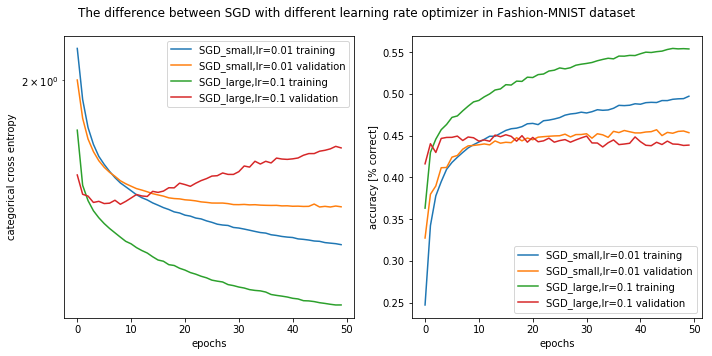

In [32]:
title = 'The difference between SGD with different learning rate optimizer in Fashion-MNIST dataset'
label1 = 'SGD_small,lr=0.01'
label2 = 'SGD_large,lr=0.1'
fig = comparison_plot(history_sgd_f, history_sgd_f_large, label1, label2, title)

In [ ]:
opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
ex3_adam_f = OneHidden(opt)

ex3_adam_f.learning(fashion_data)

history_adam_f = ex3_adam_f.get_history()
title = 'with adam on fashion mnist'
ex3_adam_f.display(title)

In [ ]:
label1 = 'SGD_opt'
label2 = 'Adam_opt'
title = 'The difference between SGD and Adam optimizer in fashion MNIST dataset'
fig = comparison_plot(history_sgd, history_adam, label1, label2, title)

**Question**: What happens if the learning rate of SGD is A) very large B) very small? Please answer A) and B) with one full sentence each (double click this markdown cell to edit).

**Answer**:
On the dataset of MNIST,
A) the categorical cross entropy is larger and more unstable but the accuracy is almost same as smaller learning rate

B) the categorical cross entropy is smaller and changes more smoothly with respect to epoches, but the accuracy is almost same as large learning rate

**Question**: At which epoch (approximately) does the Adam optimizer start to overfit (on MNIST)? Please answer with one full sentence.

**Answer**: On the dataset of MNIST, Adam optimizer start to overfit at 21th epoch because from that point overal trend of categorical cross entropy started to rise.

**Question**: Explain the qualitative difference between the loss curves and the accuracy curves with respect to signs of overfitting. Please answer with at most 3 full sentences.

**Answer**: The overfitting will happen when the overall trend of loss curve based on the validation dataset goes up and overall trend of accuracy curve based on the validation dataset goes down. However, the accuracy curve going down is not as obvious as loss curve going up. 

## Exercise 4: Model performance as a function of number of hidden neurons (8 points)

### Description

Investigate how the best validation loss and accuracy depends on the number of hidden neurons in a single layer.

1. Fit a reasonable number of models (e.g. 5) with different hidden layer sizes (between 10 and 1000 hidden neurons) to the MNIST dataset. You may use the Adam optimizer and a meaningful number of epochs (overfitting!). (3 pts)
2. Plot the best validation loss and accuracy versus the number of hidden neurons. Is the observed trend in accordance with the [general approximation theorem](https://en.wikipedia.org/wiki/Universal_approximation_theorem)? If not, what might be practical reasons for the deviation? (2 sentences max.) (3 pts)
3. Repeat steps 1. & 2. for the Fashion-MNIST dataset. (2 pts)

In this exercise we fit each model only for one initialization and random seed. In practice one would collect some statistics (e.g. 25-, 50-, 75-percentiles) for each layer size by fitting each model several times with different initializations and the random seeds. You may also want to do this here. It is a good exercise, but not mandatory as it takes quite a bit of computation time.

### Solution

In [37]:
class NeuronNum(NeuroNetSolver):
    def __init__(self,num):
        self.model = Sequential([Dense(num,input_dim=784),
                    Activation('relu'),
                      Dropout(0.2),
                     Dense(10),
                    Activation('softmax')])
        self.model.summary()
        self.model.compile(loss = 'categorical_crossentropy',  
               optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0),
               metrics = ['accuracy'])
        
def myplot(xlabel,title,x,y1,y2):
    fig, ax1, ax2 = prepare_standardplot(title, xlabel)
    fig.set_figheight(5)
    fig.set_figwidth(10)
    fig.suptitle(title)
    ax1.plot(x, y1, label='testing')
    ax2.plot(x, y2, label='testing')
    finalize_standardplot(fig, ax1, ax2)

In [ ]:
'''******************for the MNIST dataset*****************************'''
num_neuron = [50,100,200,700,1000]
scores = np.zeros((len(num_neuron),2))
for i,n in enumerate(num_neuron):
    ex4 = NeuronNum(n)
    ex4.learning(mnist_data)
    title = 'Number of neuron in hidden layer is %d' %(n)
    scores[i] = ex4.display(title)

In [ ]:
xlabel = 'number of neurons'
title = 'effect of number of neurons in one hidden layer on mnist dataset'
myplot(xlabel,title,num_neuron,scores[:,0],scores[:,1])
print(num_neuron,'\n',scores)

In [ ]:
'''******************for the Fashion-MNIST dataset*****************************'''
num_neuron = [50,100,200,700,1000]

scores = np.zeros((len(num_neuron),2))
for i,n in enumerate(num_neuron):
    ex4 = NeuronNum(n)
    ex4.learning(fashion_data)
    title = 'Number of neuron in hidden layer is %d' %(n)
    scores[i] = ex4.display(title)

In [ ]:
xlabel = 'number of neurons'
title = 'effect of number of neurons in one hidden layer on Fashion-MNIST'
myplot(xlabel,title,num_neuron,scores[:,0],scores[:,1])
print(num_neuron,'\n',scores)

Answer to question 2: The result is in accordance with the theory because with the increse of neurons in hidden layer, the expressive power of network improves and the accuracy increases as well. But there is some upper bounds for performce with respect to numbers of neurons in a single layer because the expressive power of network in a single hidden layer is saturated.

## Exercise 5: Going deeper: tricks and regularization (8 points)

### Description

Adding hidden layers to a deep network does not necessarily lead to a straight-forward improvement of performance. Overfitting can be counteracted with regularization and dropout. Batch normalization is supposed to mainly speed up convergence. Since the MNIST dataset is almost perfectly solved already by a one-hidden-layer network we use the Fashion-MNIST dataset in this exercise.

1. Add one or two hidden layers with 50 hidden neurons (each) and train the network for a sufficiently long time (at least 100 epochs). Since deep models are very expressive you will most probably encounter overfitting. Try to improve the best validation scores of the model (even if it is only a minor improvement) by experimenting with batch_normalization layers, dropout layers and l1- and l2-regularization on weights (kernels) and biases. (4 pts)
2. After you have found good settings, plot the learning curves for both models, naive (=no tricks/regularization) and tuned (=tricks + regularized), preferably together in a comparison plot. Discuss your results; refer to the model performance with only 1 hidden layer. (2 sentences max.) (2pts)
3. Fit your best performing (probably regularized deep) model also to MNIST for having a reference for the next exercise. Plot the resulting learning curves. (2 pts)

### Solution

In [47]:
class NeuroModel(NeuroNetSolver):
    def __init__(self, model):
        self.model = model
        self.model.summary()
        self.model.compile(loss = 'categorical_crossentropy',  
               optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0),
               metrics = ['accuracy'])
    def learning(self, data, epoch):
        self.history = self.model.fit(data.x, data.y, 
                   batch_size = 128,
                   epochs = epoch,
                   verbose = 1,
                   validation_data = (data.x_val, data.y_val))
        return self.history

In [121]:
def perf_vs_regu(models, data):
    
    scores = np.zeros((len(models),2))
    
    for i, model in enumerate(models):
        ex5 = NeuroModel(model)
        ex5.learning(data, 100)
        scores[i] = ex5.display('different regularization method No.%d'%(i))
        
    return scores

def myplot(x,y1,y2):
    #name = 'scores_fashion_regu.npy'
    #np.save(name,scores_fashion)
    #scores_fashion = np.load(name)  
    xlabel = 'means of regularization'
    title = 'effect of regularization in one hidden layer'
    fig, ax1, ax2 = prepare_standardplot(title, xlabel)
    fig.set_figheight(5)
    fig.set_figwidth(10)
    fig.suptitle(title)
    ax1.plot(x, y1, label='testing')
    ax2.plot(x, y2, label='testing')
    finalize_standardplot(fig, ax1, ax2)

In [124]:
'''******************for the Fashion-MNIST dataset*****************************'''

#BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', 
#                   gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones',
#                   beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None)
droprate = 0.1
models = [
          Sequential([
                    Dense(50,input_dim=784),
                     Activation('relu'),
                    Dense(50),
                     Activation('relu'),
                    Dense(10),
                     Activation('softmax')]),
          Sequential([
                    Dense(50,input_dim=784),
                     Activation('relu'),
                      Dropout(droprate), 
                    Dense(50),
                     Activation('relu'),
                      Dropout(droprate),
                    Dense(10),
                     Activation('softmax')]),
          Sequential([
                    Dense(50,input_dim=784, 
                            kernel_regularizer = regularizers.l2(0.005),
                             bias_regularizer = regularizers.l2(0.005)),
                     Activation('relu'),
                    Dense(50,kernel_regularizer = regularizers.l2(0.01),
                              bias_regularizer = regularizers.l2(0.01)),
                     Activation('relu'),
                    Dense(10),
                     Activation('softmax')]),
          Sequential([
                    Dense(50,input_dim=784),
                     BatchNormalization(),
                      Activation('relu'),
                    Dense(50),
                     BatchNormalization(),
                      Activation('relu'),
                    Dense(10),
                     Activation('softmax')])
         ]

scores_fashion = np.zeros((len(models),2))
scores_fashion = perf_vs_regu(fashion_data, models)

In [ ]:
for i in range(4):
    print('case %d: loss_test = %f, accr_test = %f'%(i,scores_fashion[i,0],scores_fashion[i,1]))
myplot(np.array([1,2,3,4],dtype=np.uint8), scores_fashion[:,0], scores_fashion[:,1])

In [ ]:
# tuned two hidden layers
model_tuned = Sequential()
model_tuned.add(Dense(50, input_dim=784,
                kernel_regularizer=regularizers.l2(0.0001),
                bias_regularizer=regularizers.l2(0.0001)))

model_tuned.add(BatchNormalization())
model_tuned.add(Activation('relu'))
model_tuned.add(Dropout(0.1))

model_tuned.add(Dense(50,kernel_regularizer=regularizers.l2(0.0001),bias_regularizer=regularizers.l2(0.0001)))
model_tuned.add(BatchNormalization())
model_tuned.add(Activation('relu'))
model_tuned.add(Dropout(0.1))


model_tuned.add(Dense(10,kernel_regularizer=regularizers.l2(0.0001),bias_regularizer=regularizers.l2(0.0001)))
model_tuned.add(BatchNormalization())
model_tuned.add(Activation('softmax'))

ex5 = NeuroModel(model_tuned)
history_tuned = ex5.learning(fashion_data, 100)


In [ ]:
# naive two  hidden layers
model_naive = Sequential()
model_naive.add(Dense(50, activation='relu', input_dim=784))
model_naive.add(Dense(50, activation='relu'))
model_naive.add(Dense(10, activation='softmax'))

ex5 = NeuroModel(model_naive)
history_naive = ex5.learning(fashion_data, 100)

In [ ]:
ex5 = NeuroModel(model_tuned)
history_tuned_mnist = ex5.learning(mnist_data, epoch=100)
score = ex5.display('Tuned model on mnist dataset')

In [ ]:
fig = comparison_plot(history_tuned, history_naive, 'Tuned', 'Naive', 'Comparison')

Answer to question 2 (comments): The overfitting is alleviated by regularization though combining dropout,batchnormalization,regularizer (naive 87.78% versus tuned 87.89%) and tuned validation curve has more oscillation. However,the one-hidden-layer model(89.11%) performs better than the hidden-hidden-layer model.

## Exercise 6: Convolutional neural networks (CNNs) (10 points)

### Description

Convolutional neural networks have an inductive bias that is well adapted to image classification.

1. Design a convolutional neural network, play with different architectures and parameters. Hint: You may get valuable inspiration from the keras [examples](https://github.com/keras-team/keras/tree/master/examples). (4 pts)
2. Plot the learning curves of the convolutional neural network for MNIST and Fashion-MNIST. (4 pts)
3. How does the CNN performance compare to the so far best performing (deep) neural network model for the two data sets? (2 sentences max.) (2 pts)

### Solution

In [44]:
class CNN(NeuroModel):
    def __init__(self, dropout_rate, image_shape):
        self.model = Sequential([
                    Conv2D(32, kernel_size=(3,3), activation = 'relu', input_shape = image_shape),
                    Conv2D(64,(3,3),activation = 'relu'),
                    MaxPooling2D(pool_size = (2,2)),
                    Dropout(dropout_rate),  #0.25
                    Flatten(),
                    Dense(128, activation = 'relu'),
                    Dropout(droprate),  #0.5
                    Dense(10, activation = 'softmax')])
        self.model.summary()
        self.model.compile(loss = 'categorical_crossentropy',  
               optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0),
               metrics = ['accuracy'])  # Possible reason lr =0.01
    

In [ ]:
'''******************for the MNIST dataset*****************************'''
print(K.image_data_format())

x = x_train / 255
x_val = x_test / 255
x = x[:, :, :, np.newaxis].astype('float32')
x_val = x_val[:, :, :, np.newaxis].astype('float32')
mnist_cnn_data = DataSet(x,ty_train,x_val,ty_test)

droprate = 0.2
im_shape = (28,28,1)
title = 'cnn on mnist dataset after 12 epoches'

ex6 = CNN(droprate, im_shape)
ex6.learning(mnist_cnn_data, 12)
ex6.display(title)

In [ ]:
'''******************for the Fashion-MNIST dataset*****************************'''
x = x_fashion_train / 255
x_val = x_fashion_test / 255
x = x[:, :, :, np.newaxis].astype('float32')
x_val = x_val[:, :, :, np.newaxis].astype('float32')
fashion_cnn_data = DataSet(x,ty_fashion_train,x_val,ty_fashion_test)

droprate = 0.2
im_shape = (28,28,1)
title = 'cnn on mnist dataset after 12 epoches'

ex6 = CNN(droprate, im_shape)
ex6.learning(fashion_cnn_data, 12)
ex6.display(title)

Answer to question 3: The performance of CNN is better than that of one-hidden full-connected layers network, with 99.11% versus 98.1% on MNIST dataset and with 92.5% versus 89.11% on Fashion-MNIST dataset.

## Exercise 7: Sigmoidal activation function and batch-normalization (6 points)

### Description:

In the original publication of batch normalization [Ioffe and Szegedy, 2014](https://arxiv.org/pdf/1502.03167.pdf), the authors mention a particularly beneficial effect of their method on networks with sigmoidal activation functions. This is because such networks usually suffer from saturating activations/vanishing gradients. Here we want to reproduce this behaviour (Chose either MNIST or Fashion-MNIST for this exercise).

1. Implement the same convolutional network as in the previous exercise, but using the sigmoid activation function instead of the standard choice ReLU. Train the network for a reasonable amount of time. What do you observe? (1 sentence max.) (3 pts)
2. Add batch-normalization layers to all convolutional and fully-connected layers (i.e. before each layer with learnable parameters). How does the performance change? Can the network reach the ReLU-CNN performance of the previous exercise? (1 sentence max.) (3 pts)
3. **BONUS (optional, not graded**): Investigate our initial guess that saturating activity/vanishing gradients might be the cause of this behaviour. For that, create histograms of the hidden activitions for different hidden layers for the sigmoid-CNN and the sigmoid-CNN with batch-normalization (counting over both, samples and neurons per layer). You may only chose layers with learnable parameters. What do you observe?
Hint: You can use the [keract](https://github.com/philipperemy/keract) package to access neural activation values for all layers of your network model.



### Solution:

In [117]:
def perf_vs_batch(data, models):
    for i, model in enumerate(models):
        ex7 = NeuroModel(model)
        ex7.learning(data, 5)
        ex7.display('with and without batch-normalization cases of cnn using sigmoid')

In [ ]:
'''******************for the Fashion-MNIST dataset*****************************'''

im_shape = (28,28,1)
droprate = 0.2

models = [
         Sequential([
                    Conv2D(32, kernel_size=(3,3), activation = 'sigmoid', input_shape = im_shape),
                    Conv2D(64,(3,3),activation = 'sigmoid'),
                    MaxPooling2D(pool_size = (2,2)),
                    Dropout(droprate),
                    Flatten(),
                    Dense(128, activation = 'sigmoid'),
                    Dropout(droprate),
                    Dense(10, activation = 'softmax')]),
    
          Sequential([
                    Conv2D(32, kernel_size=(3,3), activation = 'sigmoid', input_shape = im_shape),
                    BatchNormalization(),
                    #Dropout(droprate),
                    Conv2D(64,(3,3),activation = 'sigmoid'),
                    BatchNormalization(),
                    MaxPooling2D(pool_size = (2,2)),
                    Dropout(droprate),
                    Flatten(),
                    Dense(128, activation = 'sigmoid'),
                    BatchNormalization(),
                    Dropout(droprate),
                    Dense(10, activation = 'softmax')])
         ]

perf_vs_batch(fashion_data, models)

Answer to question 1:  After enough training time, the performance(val_accr = 86.39%) is significantly worse than that of network with Relu activation function (val_accr = 92.5%).

Answer to question 2: It will improve the performance of network with sigmoid function from 86.39% to 90.96%, but the final result is slightly worse than that with Relu function.